# **Libraries**

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
import numpy as np
import shap
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Simple Neural Network

In [36]:
class Model(nn.Module):
  def __init__(self, in_features=4, h1=8, h2=9, out_features=3):
    super().__init__()
    self.fc1 = nn.Linear(in_features, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.out = nn.Linear(h2, out_features)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)

    return x

In [37]:
torch.manual_seed(35)
model = Model()

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
url = 'https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv'
data = pd.read_csv(url)


In [40]:
data.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [41]:
data['variety'] = data['variety'].replace('Setosa', 0.0)
data['variety'] = data['variety'].replace('Versicolor', 1.0)
data['variety'] = data['variety'].replace('Virginica', 2.0)
data.head()

/tmp/ipython-input-2095112689.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['variety'] = data['variety'].replace('Virginica', 2.0)


,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [42]:
X = data.drop('variety', axis=1)
y = data['variety']

In [43]:
X = X.values
y = y.values

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

In [45]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

In [46]:
# Convert y labels to tensors long
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#  Model Training

In [48]:
epochs = 100
losses = []
for i in range(epochs):
  # Go forward and get a prediction
  y_pred = model.forward(X_train) # Get predicted results

  # Measure the loss/error, gonna be high at first
  loss = criterion(y_pred, y_train)

  # Keep Track of our losses
  losses.append(loss.detach().numpy())

  if i % 10 == 0:
    print(f'Epoch: {i} and loss: {loss}')

  #take the error rate of forward propagation and feed it back
  # thru the network to fine tune the weights
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


Epoch: 0 and loss: 1.1688206195831299
Epoch: 10 and loss: 0.9637446999549866
Epoch: 20 and loss: 0.706683874130249
Epoch: 30 and loss: 0.47058382630348206
Epoch: 40 and loss: 0.32324737310409546
Epoch: 50 and loss: 0.20510302484035492
Epoch: 60 and loss: 0.12802031636238098
Epoch: 70 and loss: 0.09105848520994186
Epoch: 80 and loss: 0.07478222995996475
Epoch: 90 and loss: 0.06659011542797089


Text(0.5, 0, 'Epoch')

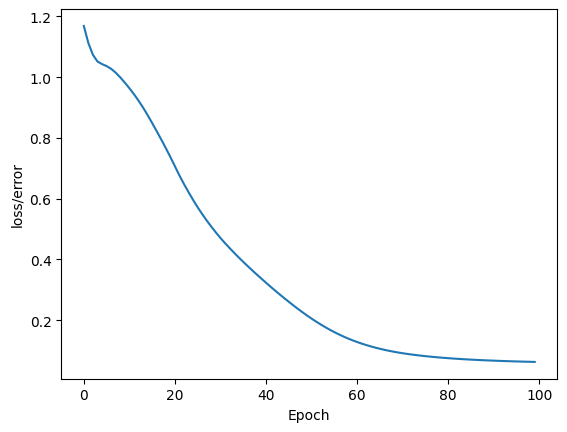

In [49]:
plt.plot(range(epochs), losses)
plt.ylabel("loss/error")
plt.xlabel('Epoch')

# **Testing**

In [50]:
with torch.no_grad():  # Basically turn off back propogation
  y_eval = model.forward(X_test) # X_test are features from our test set, y_eval will be predictions
  loss = criterion(y_eval, y_test)

In [51]:
loss

tensor(0.0447)

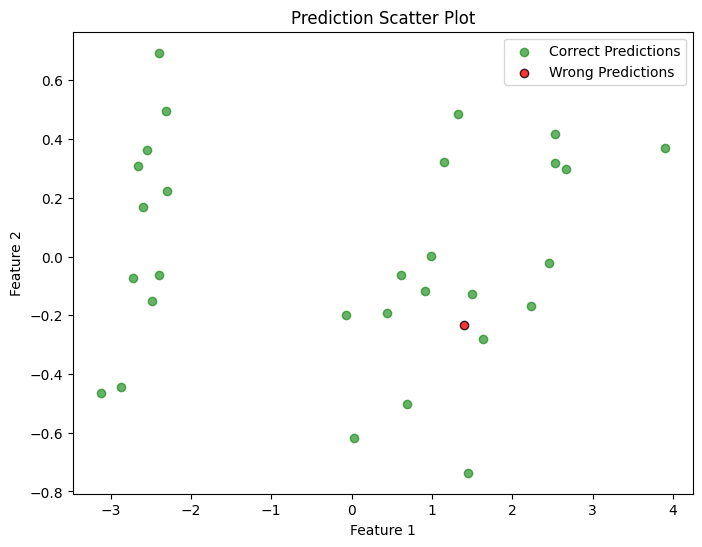

In [52]:
X_np = X_test.numpy() if isinstance(X_test, torch.Tensor) else X_test
y_np = y_test.numpy() if isinstance(y_test, torch.Tensor) else y_test

if X_np.shape[1] > 2:
    pca = PCA(n_components=2)
    X_vis = pca.fit_transform(X_np)
else:
    X_vis = X_np

preds = []
correct_mask = []
with torch.no_grad():
    for i, data in enumerate(X_test):
        y_val = model(data)
        pred = y_val.argmax().item()
        preds.append(pred)
        correct_mask.append(pred == y_test[i].item())

preds = np.array(preds)
correct_mask = np.array(correct_mask)

plt.figure(figsize=(8,6))

plt.scatter(X_vis[correct_mask,0], X_vis[correct_mask,1],
            c='green', label='Correct Predictions', alpha=0.6)

plt.scatter(X_vis[~correct_mask,0], X_vis[~correct_mask,1],
            c='red', label='Wrong Predictions', alpha=0.8, edgecolors='k')

plt.title("Prediction Scatter Plot")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [53]:
new_iris = torch.tensor([4.7, 3.2, 1.3, 0.2])

In [54]:
with torch.no_grad():
  print(model(new_iris))

tensor([ 10.7035,   5.0332, -22.2359])


In [55]:
newer_iris = torch.tensor([5.9, 3.0, 5.1, 1.8])

In [56]:
with torch.no_grad():
  print(model(newer_iris))

tensor([-6.9234,  4.4240,  6.9284])


In [57]:
torch.save(model.state_dict(), 'my_really_awesome_iris_model.pt')

In [58]:
import torch

# Convert to float tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)


/tmp/ipython-input-3830395433.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
/tmp/ipython-input-3830395433.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
/tmp/ipython-input-3830395433.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
/tmp/ipython-input-3830395433.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.de

/tmp/ipython-input-4132284924.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_np, feature_names=features)
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots

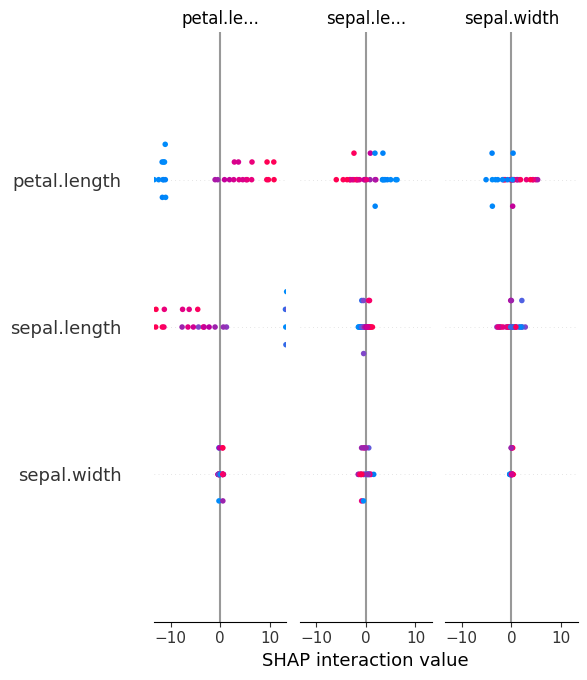

 SHAP summary plot displayed successfully.


In [59]:
model.eval()
explainer = shap.GradientExplainer(model, X_train_tensor)
shap_values = explainer.shap_values(X_test_tensor)
X_test_np = X_test_tensor.detach().numpy()
features = ["sepal.length", "sepal.width", "petal.length", "petal.width"]
shap.summary_plot(shap_values, X_test_np, feature_names=features)

print(" SHAP summary plot displayed successfully.")
